<h3>Галлямов Артур, КЭ-403, лабораторная работа №1</h3>

Постановка задания:
1. Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).
3. Выполните визуализацию результатов экспериментов в виде следующих диаграмм:
сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;
количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.
4. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
формулировка задания; 
гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
рисунки с результатами визуализации; 
пояснения, раскрывающие смысл полученных результатов.

[Гиперссылка на репозиторий](https://github.com/gamingKenku/analytical-info-processing-tech/tree/main/lab1)

Реализация алгоритма Aprirori была взята из библиотеки MLxtend, используемой для решения задач машинного обучения и анализа данных. 
Для визуализации результатов расчета была использована библиотека Matplotlib.

In [21]:
# Импорт необходимых библиотек
import time
import enum
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt

<h3> Программа поиска частых наборов </h3>

In [31]:
# Чтение набора из файла и преобразование в список python
df = pd.read_csv('baskets.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
1,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Перечисление методов сортировки
class SortMethod(enum.Enum):
    by_support = 'support'
    by_itemsets = 'itemsets'

def freq_itemsets(df: pd.DataFrame, min_support: float, sort_method: SortMethod=SortMethod.by_support):
    def sort_by_support(df: pd.DataFrame):
        return df.sort_values('support', ascending=False)

    def sort_by_itemsets(df: pd.DataFrame):
        return df.sort_values('itemsets')
    
    SORT_METHODS = {
        SortMethod.by_itemsets: sort_by_itemsets,
        SortMethod.by_support: sort_by_support
    }
    
    # Преобразование датасета для использования в алгоритме
    df = df.values.tolist()
    df = [[x for x in l if str(x) != 'nan'] for l in df]
    te = TransactionEncoder()
    te_ary = te.fit(df).transform(df)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Выполнение алгоритма
    apr_df = apriori(df, min_support, use_colnames=True)

    # Сортировка заданным методом
    apr_df = SORT_METHODS[sort_method](apr_df)

    return apr_df

Пример поиска частых наборов при пороге поддержки 5%, сортированный по значениям поддержки:

In [24]:
supp_sorted_df = freq_itemsets(df, 0.05, SortMethod.by_support).head(10)
supp_sorted_df

,support,itemsets
11,0.238368,(минеральная вода)
10,0.187975,(макароны)
24,0.179709,(яйца)
7,0.170911,(картофель-фри)
22,0.163845,(шоколад)
5,0.132116,(зеленый чай)
12,0.129583,(молоко)
2,0.098254,(говяжий фарш)
3,0.095321,(замороженные овощи)
0,0.095054,(блинчики)


Выходной датасет показывает результаты выполнения алгоритма: значения поддержки и соответствующие им наборы.

<h3>Эксперименты</h3>

Сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки

<function matplotlib.pyplot.show(close=None, block=None)>

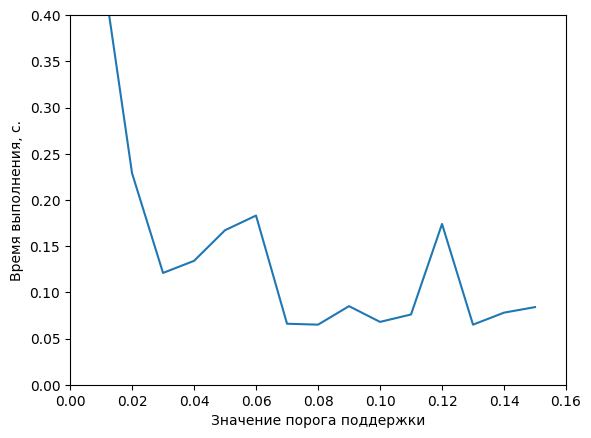

In [25]:
# Начальное значение порога поддержки и списки, используемые для построения графика
support = 0.01
support_list = []
execution_time_list = []

while support <= 0.15:
    start_time = time.time()
    apr_df = freq_itemsets(df, support, SortMethod.by_support)
    execution_time_list.append(time.time() - start_time)
    support_list.append(support)
    support += 0.01

plt.plot(support_list, execution_time_list)
plt.axis((0.0, 0.16, 0.0, 0.4))
plt.xlabel('Значение порога поддержки')
plt.ylabel('Время выполнения, с.')
plt.show


По построенному графику видно, что время выполнения алгоритма зависит от значения порога поддержки и обратно пропорционально ему: чем ниже порог, тем дольше выполнение. Также видны скачки времени выполнения в случайные моменты, но в целом тенденция остается такой же.

<function matplotlib.pyplot.show(close=None, block=None)>

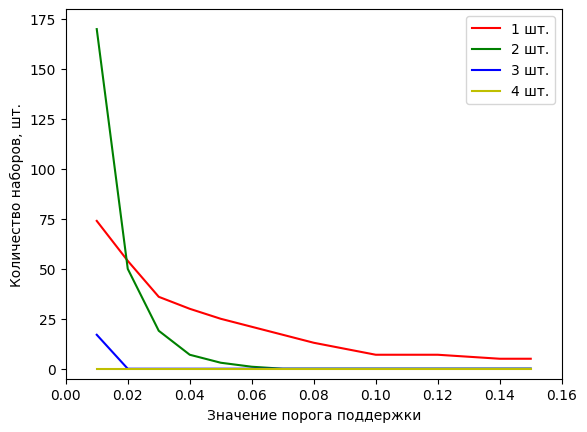

In [26]:
# Начальное значение порога поддержки и списки, используемые для построения графика
amount_1 = []
amount_2 = []
amount_3 = []
amount_4 = []
support = 0.01
support_list = []

while support <= 0.15:
    apr_df = freq_itemsets(df, support, SortMethod.by_support)
    apr_df['length'] = apr_df['itemsets'].apply(lambda x: len(x))

    amount_1.append(apr_df['length'].value_counts().get(1, 0))
    amount_2.append(apr_df['length'].value_counts().get(2, 0))
    amount_3.append(apr_df['length'].value_counts().get(3, 0))
    amount_4.append(apr_df['length'].value_counts().get(4, 0))
    
    support_list.append(support)
    support += 0.01

plt.plot(support_list, amount_1, 'r-', support_list, amount_2, 'g-', support_list, amount_3, 'b-', support_list, amount_4, 'y-')
plt.axis((0.0, 0.16, -5, 180))
plt.ylabel('Количество наборов, шт.')
plt.xlabel('Значение порога поддержки')
plt.legend(('1 шт.', '2 шт.', '3 шт.', '4 шт.'))
plt.show

Из построенного графика видно, что общее количество выявленных наборов уменьшается с увеличением порога поддержки. Также видно, что при низком пороге поддержки наиболее популярны наборы из двух элементов, а при его увеличении - из одного.

<h3>Галлямов Артур, КЭ-403, лабораторная работа №2</h3>

1. Доработайте программу из задания Поиск частых наборов, чтобы она также выполняла поиск ассоциативных правил. Список результирующих правил должен выдаваться в удобочитаемом виде (антецедент→консеквент) с указанием поддержки и достоверности каждого правила. Дополнительные параметры программы: порог достоверности, способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).
2. Проведите эксперименты на наборах из задания 1. В экспериментах Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%).
3. Выполните визуализацию полученных результатов в виде следующих диаграмм:
- сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;
- общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности.
4. Подготовьте список правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов (разумное количество). Проанализируйте и изложите содержательный смысл полученного результата.
5. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
- формулировка задания; 
- гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами; 
- рисунки с результатами визуализации; 
- пояснения, раскрывающие смысл полученных результатов.


In [44]:
from mlxtend.frequent_patterns import association_rules
import math

In [32]:
df = pd.read_csv('baskets.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
1,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
class RulesSortMethod(enum.Enum):
    by_support = 'support'
    lexicographically = 'letters'

def find_association_rules(df: pd.DataFrame, min_support: float, sort_method: RulesSortMethod, min_confidence: float):
    def sort_by_support(df: pd.DataFrame):
        return df.sort_values('support', ascending=False)

    def sort_lexicographically(df: pd.DataFrame):
        return df.sort_values(['antecedents', 'consequents'])
    
    SORT_METHODS = {
        RulesSortMethod.lexicographically: sort_lexicographically,
        RulesSortMethod.by_support: sort_by_support
    }

    apr_df = freq_itemsets(df, min_support, SortMethod.by_support)

    rules_df = association_rules(apr_df, metric="confidence", min_threshold=min_confidence)

    rules_df = rules_df.drop(columns=["antecedent support", "consequent support", "lift", "leverage", "conviction", "zhangs_metric"])
    
    rules_df = SORT_METHODS[sort_method](rules_df)

    return rules_df

In [33]:
rules_df = find_association_rules(df, 0.002, RulesSortMethod.by_support, 0.7)
rules_df

,antecedents,consequents,support,confidence
0,"(эскалоп, грибной соус)",(макароны),0.004266,0.744186
1,"(замороженные овощи, суп, молоко)",(минеральная вода),0.003066,0.766667
2,"(яйца, растительное масло, макароны)",(минеральная вода),0.003066,0.718750
3,"(замороженные овощи, оливковое масло, шоколад)",(минеральная вода),0.002800,0.700000
4,"(яйца, оливковое масло, молоко)",(минеральная вода),0.002666,0.714286
5,"(макароны, обезжиренное молоко)",(минеральная вода),0.002533,0.730769
6,"(замороженные овощи, говяжий фарш, креветки)",(макароны),0.002533,0.791667
7,"(макароны, суп, блинчики)",(минеральная вода),0.002266,0.772727
8,"(макароны, растительное масло, блинчики)",(минеральная вода),0.002266,0.739130
9,"(молоко, помидоры, рис)",(макароны),0.002133,0.800000


[0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


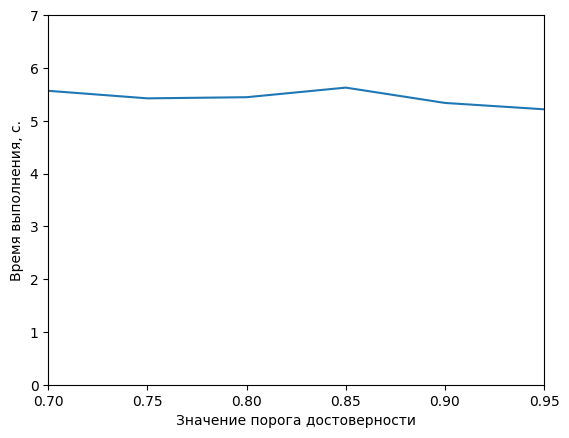

In [46]:
confidence = 0.7
support = 0.002
confidence_list = []
execution_time_list = []

while confidence <= 0.95:
    start_time = time.time()
    rules_df = find_association_rules(df, support, RulesSortMethod.by_support, confidence)
    execution_time_list.append(time.time() - start_time)
    confidence_list.append(confidence)
    confidence += 0.05
    confidence = math.floor(confidence*100)/100.0

plt.plot(confidence_list, execution_time_list)
plt.axis((0.7, 0.95, 0.0, 7))
plt.xlabel('Значение порога достоверности')
plt.ylabel('Время выполнения, с.')
plt.show

print(confidence_list)

<function matplotlib.pyplot.show(close=None, block=None)>

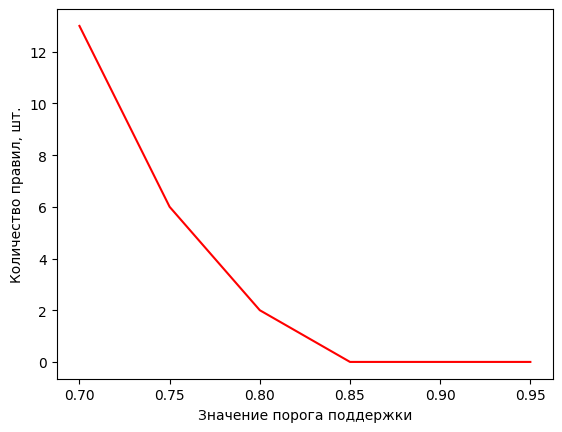

In [51]:
amount_list = []
confidence = 0.7
confidence_list = []

while confidence <= 0.95:
    rules_df = find_association_rules(df, support, RulesSortMethod.by_support, confidence)
    amount_list.append(rules_df.shape[0])    
    confidence_list.append(confidence)
    confidence += 0.05
    confidence = math.floor(confidence*100)/100.0


plt.plot(confidence_list, amount_list, 'r-')
plt.ylabel('Количество правил, шт.')
plt.xlabel('Значение порога поддержки')
plt.show